In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
df=pd.read_csv("/content/stock_data.csv")

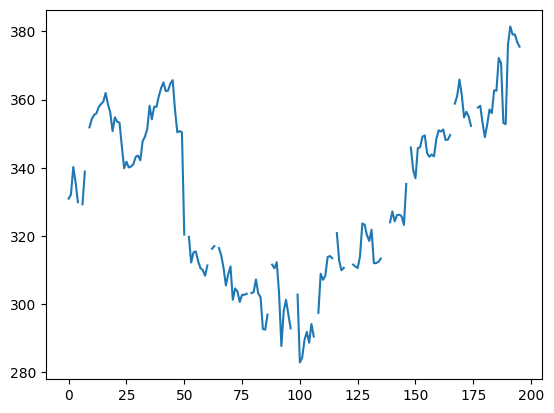

In [ ]:
plt.plot(df['Close'])

In [ ]:
import yfinance as yf

tickers = ["TATASTEEL.NS", "HINDALCO.NS", "DLF.NS"]
dfs = [yf.download(ticker, start="2023-01-01", end="2024-01-01") for ticker in tickers]


/tmp/ipython-input-33-1188561620.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfs = [yf.download(ticker, start="2023-01-01", end="2024-01-01") for ticker in tickers]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-33-1188561620.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfs = [yf.download(ticker, start="2023-01-01", end="2024-01-01") for ticker in tickers]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-33-1188561620.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfs = [yf.download(ticker, start="2023-01-01", end="2024-01-01") for ticker in tickers]
[*********************100%***********************]  1 of 1 completed


In [ ]:
def create_sequences(df, window_size):
    X = []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size].values
        X.append(window)
    return X


In [ ]:
all_sequences = []
for df in dfs:
    all_sequences.extend(create_sequences(df[['Open', 'High', 'Low', 'Close', 'Volume']], 30))


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout


In [ ]:
# --- Step 1: Download and Prepare Training Data ---
tickers = ["TATASTEEL.NS", "HINDALCO.NS", "VEDL.NS", "ADANIENT.NS", "DLF.NS"]
start_date = "2019-01-01"
end_date = "2024-01-01"

# Download OHLCV data for each stock
raw_data = yf.download(tickers, start=start_date, end=end_date)

# Flatten multi-level columns
data = raw_data.copy()
data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Extract OHLCV for each ticker
ohlcv_data = pd.concat([
    data[[f"Open_{t}", f"High_{t}", f"Low_{t}", f"Close_{t}", f"Volume_{t}"]].rename(
        columns={
            f"Open_{t}": "Open", f"High_{t}": "High", f"Low_{t}": "Low",
            f"Close_{t}": "Close", f"Volume_{t}": "Volume"
        }).assign(Ticker=t)
    for t in tickers
], axis=0)


/tmp/ipython-input-85-1930309835.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


In [ ]:
ohlcv_data.head()

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2019-01-01,42.850117,42.891004,41.995566,42.175472,41281730,TATASTEEL.NS
2019-01-02,41.378163,41.443585,40.233315,40.368244,117473500,TATASTEEL.NS
2019-01-03,40.315089,40.327355,39.272459,39.354233,135329440,TATASTEEL.NS
2019-01-04,39.333786,40.302821,39.215214,39.877590,104800720,TATASTEEL.NS
2019-01-07,40.511349,40.969287,39.570935,39.701775,84067870,TATASTEEL.NS


In [ ]:
ohlcv_data.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Ticker,0


In [ ]:
scaler = StandardScaler()
features = ["Open", "High", "Low", "Close", "Volume"]
ohlcv_data[features] = scaler.fit_transform(ohlcv_data[features])


In [ ]:
def create_sequences(df, window=30):
    X, y = [], []
    for i in range(len(df) - window):
        seq = df.iloc[i:i+window][features].values
        target = df.iloc[i+window]['Close']  # only predict Close
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# Apply on each stock separately, then combine
X_total, y_total = [], []
for ticker in tickers:
    df_stock = ohlcv_data[ohlcv_data['Ticker'] == ticker]
    X, y = create_sequences(df_stock)
    X_total.append(X)
    y_total.append(y)

X_train = np.concatenate(X_total, axis=0)
y_train = np.concatenate(y_total, axis=0)

In [ ]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(30, 5)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0991
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0146
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0180
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0088
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0096
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0098
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0081
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0100
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0080
Epoch 10/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0076
Epoch 11/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0082
Epoch 12/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0065
Epoch 13/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0079
Epoch 14/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0071
Epoch 15/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step 

In [ ]:
target_ohlcv = pd.read_csv("/content/stock_data.csv", parse_dates=True, index_col=0)
features = ["Open", "High", "Low", "Close", "Volume"]

In [ ]:
target_ohlcv.head()

,High,Low,Open,Volume,Close
Date,,,,,
01-01-2024,333.926313,330.400002,333.258269,1478688.0,330.967834
02-01-2024,334.785146,330.514440,330.514440,NaN,332.165466
03-01-2024,341.179300,329.655551,331.635823,10046344.0,340.239258
04-01-2024,341.704144,331.025005,341.188806,11098328.0,335.729919
05-01-2024,336.493453,328.935023,335.839738,7713688.0,329.932312


In [ ]:
# Save original for visualization
target_original = target_ohlcv.copy()
target_original.index=pd.to_datetime(target_original.index,format="%d-%m-%Y")
# Identify missing Close prices
mask_missing = target_ohlcv["Close"].isna()

# Fill temporarily for scaling
target_ohlcv_filled = target_ohlcv.ffill()
scaled_target = scaler.transform(target_ohlcv_filled[features])

# Fill temporarily for scaling
target_ohlcv_filled = target_ohlcv.ffill()
scaled_target = scaler.transform(target_ohlcv_filled[features])

# Predict Close where missing using windowed input
reconstructed = scaled_target.copy()
window = 30
for i in range(window, len(reconstructed)):
    if mask_missing.iloc[i]:
        window_seq = reconstructed[i-window:i]
        pred = model.predict(window_seq[np.newaxis, ...], verbose=0)[0, 0]
        reconstructed[i, 3] = pred  # update Close column (index 3)

# Inverse transform back
reconstructed_full = scaler.inverse_transform(reconstructed)
target_ohlcv["Imputed_Close"] = reconstructed_full[:, 3]


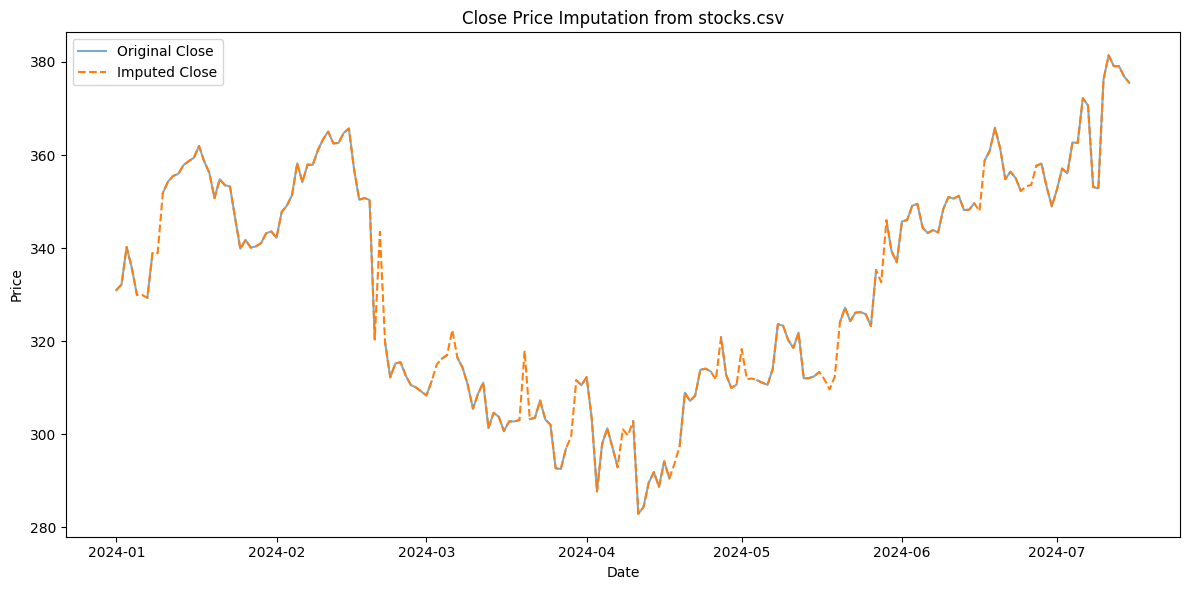

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_original.index, target_original["Close"], label="Original Close", alpha=0.6)
plt.plot(target_original.index, target_ohlcv["Imputed_Close"], label="Imputed Close", linestyle="--")
plt.title(f"Close Price Imputation from stocks.csv")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
target_ohlcv.head(100)

,High,Low,Open,Volume,Close,Imputed_Close
Date,,,,,,
01-01-2024,333.926313,330.400002,333.258269,1478688.0,330.967834,330.967834
02-01-2024,334.785146,330.514440,330.514440,NaN,332.165466,332.165466
03-01-2024,341.179300,329.655551,331.635823,10046344.0,340.239258,340.239258
04-01-2024,341.704144,331.025005,341.188806,11098328.0,335.729919,335.729919
05-01-2024,336.493453,328.935023,335.839738,7713688.0,329.932312,329.932312
...,...,...,...,...,...,...
06-04-2024,303.482533,294.048797,301.573838,9832744.0,297.174286,297.174286
07-04-2024,302.623656,287.463833,298.233656,9081776.0,292.941803,292.941803
08-04-2024,296.892809,291.090370,293.080195,5750544.0,NaN,295.462138


In [ ]:
df=target_ohlcv["Imputed_Close"]

In [ ]:
df.to_csv("results.csv")